<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/ConvNeXt_CenterLoss_Face_Classification_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Classification/Verification with ConvNeXt and CenterLoss

ConvNeXt: [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) \
DataSet: [Kaggle Face Verification](https://www.kaggle.com/competitions/11-785-f22-hw2p2-verification)

# I. Preliminaries

### Import libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import gc

import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import torchvision

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.metrics import accuracy_score
import glob
    
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# Training configurations
config = {
    'batch_size': 32,
    'lr': 0.1,
    'epochs': 20
}

### Loading files

In [ ]:
if not os.path.exists("/root/.kaggle/kaggle.json"):
    !mkdir /root/.kaggle

    with open("/root/.kaggle/kaggle.json", "w+") as f:
        f.write('Your Kaggle API')

    !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir '/content/data'

!kaggle competitions download -c 11-785-f22-hw2p2-classification
!unzip -qo '11-785-f22-hw2p2-classification.zip' -d '/content/data'

!kaggle competitions download -c 11-785-f22-hw2p2-verification
!unzip -qo '11-785-f22-hw2p2-verification.zip' -d '/content/data'

11-785-f22-hw2p2-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
11-785-f22-hw2p2-verification.zip: Skipping, found more recently modified local copy (use --force to force download)


---

# II. Datasets and DataLoaders

### Datasets

In [ ]:
DATA_DIR = '/content/data/11-785-f22-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR = os.path.join(DATA_DIR, "classification/train") 
VAL_DIR = os.path.join(DATA_DIR, "classification/dev")
TEST_DIR = os.path.join(DATA_DIR, "classification/test")

In [ ]:
# Image Augmentations
train_transforms = torchvision.transforms.Compose([ 
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.RandomAffine(degrees=10, scale=(0.75, 1.2)),
                    torchvision.transforms.ColorJitter(brightness=0.3, hue=0.2, saturation=0.5),
                    torchvision.transforms.RandomHorizontalFlip(0.5),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

# We only do ToTensor and Normalize on the evaluation dataset
eval_transforms = torchvision.transforms.Compose([ 
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])



In [ ]:
# Dataset class for test dataset
class VGGFaceTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir

        # Get the path of 
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        # Transform the image to tensor
        to_tensor = torchvision.transforms.ToTensor()
        img = to_tensor(img)

        # Normalize the image
        mean = img.mean((1, 2))
        std = img.std((1, 2))
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img_norm = normalize(img)

        # return img_norm
        return img_norm

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=eval_transforms)
test_dataset = VGGFaceTestDataset(TEST_DIR)

### DataLoaders

In [ ]:
# Creating dataloaders for all three datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config['batch_size'], 
                                           shuffle = True, pin_memory = True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config['batch_size'], 
                                         shuffle = False, pin_memory = True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                                          drop_last = False)

In [ ]:
print("Number of classes: ", len(train_dataset.classes))
print("No. of train images: ", train_dataset.__len__())
print("No. of val images: ", val_dataset.__len__())
print("Shape of image: ", train_dataset[0][0].shape)
print("Batch size: ", config['batch_size'])
print("Train batches: ", train_loader.__len__())
print("Val batches: ", val_loader.__len__())

Number of classes:  7000
No. of train images:  140000
No. of val images:  35000
Shape of image:  torch.Size([3, 224, 224])
Batch size:  32
Train batches:  4375
Val batches:  1094


### Sanity Check

In [ ]:
def plot_samples(dataloader):
    
    imgs, labels = next(iter(dataloader))
    sample = [random.randint(0, config["batch_size"]) for i in range(4)]
    imgs = imgs[sample].permute(0, 2, 3, 1)
    labels = labels[sample]
    
    fig, ax = plt.subplots(1, 4, figsize=(12, 6))
    for i in range(4):
        # Because the image is normalized, which makes color wired,
        # so we only show one channel in grayscale here for sanity check
        ax[i].imshow(imgs[i][:, :, 0], cmap="gray", vmin=0, vmax=1)
        ax[i].axis(False)
        ax[i].set_title(f"Class: {labels[i].item()}")
    plt.show()

Train Data:


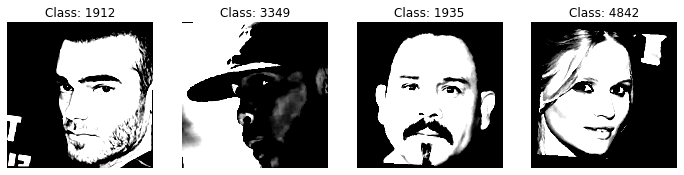

Validation Data:


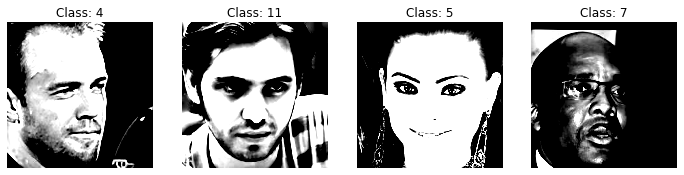

In [ ]:
print("Train Data:")
plot_samples(train_loader)

print("Validation Data:")
plot_samples(val_loader)

---

# III. ConvNeXt Model from Scratch

### DropPath
randomly "drop" some of the paths through the network by setting the activations of certain neurons to zero. This helps to prevent the network from becoming too dependent on any one set of weights, and can improve its performance on test data. <br>
Reference: [DropPath GitHub](https://github.com/rwightman/pytorch-image-models/blob/b944546200f81ebe5f688cb523aaf3423a437b81/timm/models/layers/drop.py#L137)

In [ ]:
def drop_path(x, drop_prob=0.0, training=False, scale_by_keep=True):
    '''
    By setting scale_by_keep to True, the model factorize some paths rather
    than cancel out them
    '''
    
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0], ) + (1, ) * (x.ndim - 1)
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor

In [ ]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0, scale_by_keep=True):
        super().__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep
    
    def forward(self, X):
        return drop_path(X, self.drop_prob, self.training, self.scale_by_keep)
    
    def extra_repr(self):
        return f"drop_prob={round(self.drop_prob, 3):0.3f}"

### ConvNeXt Block

In [ ]:
class Block(nn.Module):
    '''
    Args: 
        dim (int): number of input channels
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_val (float): Initialize value for Layer Scale. Default: 1e-6
    '''
    def __init__(self, dim, drop_path=0, layer_scale_init_val=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # This is depth-wise convolution
        # In this task we use BatchNorm rather than LayerNorm proposed in the paper
        self.norm = nn.BatchNorm2d(dim)
        self.pwconv1 = nn.Linear(dim, 4*dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4*dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_val * torch.ones((dim)), 
                                  requires_grad=True) if layer_scale_init_val > 0 else None # Layer-wise lr decay
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity() 
    
    def forward(self, X):
        input = X
        X = self.dwconv(X)
        #print(X.shape)
        X = self.norm(X)
        X = X.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        X = self.pwconv1(X)
        #print(X.shape)
        X = self.act(X)
        X = self.pwconv2(X) 
        #print(X.shape)
        if self.gamma is not None:
            X = self.gamma * X
        X = X.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)
        
        X = input + self.drop_path(X)
        return X

## ConvNeXt Body

In [ ]:
class ConvNeXt(nn.Module):
    '''
    Args:
        in_chans (int): Number of input channels. Default: 3
        num_classes (int): Number of classes for classification. Default: 7000
        depths (tuple(int)): Number of blocks at each stage. Default: (3, 3, 27, 3)
        dims (tuple(int)): The dimension at each stage. Default: (128, 256, 512, 1024) <- this is the setup of base model
        drop_path_rate (float): Stochastic depth rate. Default: 0
        layer_scale_init_val (float): Init value for Layer Scale (layer-wise learning rate decay). Default: 1e-6 
        head_init_scale (float): Init scaling value for classifier weights and biases. default: 1
        
        
        Models:
        tiny: depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]
        small: depths=[3, 3, 27, 3], dims=[96, 192, 384, 768]
        base: depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024]
        large: depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536]
    '''
    def __init__(self, in_chans=3, num_classes=7000, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_val=1e-6, head_init_scale=1.):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # First and three intermediate dowmsampling conv layers

        stem = nn.Sequential(nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
                             nn.BatchNorm2d(dims[0]))
        self.downsample_layers.append(stem)
        
        # Creating a downsampling layers
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.BatchNorm2d(dims[i]),
                nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
            )
            self.downsample_layers.append(downsample_layer)
        

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting residule blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0

        # Creating ConvNeXt blocks
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur+j], 
                        layer_scale_init_val=layer_scale_init_val) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]
        
        self.norm = nn.BatchNorm1d(dims[-1])
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    # Weight initialization
    def _init_weights(self, module):
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)

    # Reture embedded features
    def forward_feats(self, X):
        for i in range(4):
            X = self.downsample_layers[i](X)
            X = self.stages[i](X)
        return self.norm(X.mean([-2, -1])) # Global average pooling, (N, C, H, W) -> (N, C)
    
    # Return classification
    def forward(self, X, return_feats=False):
        X = self.forward_feats(X)
        if return_feats:
            return X, self.head(X)
        else:
            return self.head(X)

In [ ]:
torch.cuda.empty_cache()
model = ConvNeXt(drop_path_rate=0.20).to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       BatchNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
       BatchNorm2d-4           [-1, 96, 56, 56]             192
            Linear-5          [-1, 56, 56, 384]          37,248
              GELU-6          [-1, 56, 56, 384]               0
            Linear-7           [-1, 56, 56, 96]          36,960
          Identity-8           [-1, 96, 56, 56]               0
             Block-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           4,800
      BatchNorm2d-11           [-1, 96, 56, 56]             192
           Linear-12          [-1, 56, 56, 384]          37,248
             GELU-13          [-1, 56, 56, 384]               0
           Linear-14           [-1, 56,

---

# IV. Training Setups

### Center Loss

Center loss helps to improve discriminative feature learning for Face Verification task
$$\mathcal{L_C} = \frac{1}{2}\sum_{i=1}^{m}\|x_i - c_{yi} \|^2_2$$

In [ ]:
class CenterLoss(nn.Module):
    """Center Loss
        Center Loss Paper:
        https://ydwen.github.io/papers/WenECCV16.pdf
    Args:
        nn (_type_): _description_
    """
    def __init__(self, num_classes=7000, feat_dim=768):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        centers = self.centers[labels]
        dist = torch.sum((x - centers) ** 2, axis=1)
        # Each element in dist is actually the Center Loss of each input
        # Here we have to first wrap 'dist' inside torch.clamp() function, because log(0) will cause NaN output. 
        dist = torch.clamp(dist, min=1e-12, max=1e+12)
        # To avoid the 0 in 'dist', we will set the lower bound in 'dist' to a value that is close to 0
        loss = torch.sum(dist) / (2 * len(x))
        return loss

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9 ,lr=config['lr'], weight_decay=1e-4, nesterov=True)

centerLoss = CenterLoss()
optimizer_center_loss = torch.optim.SGD(centerLoss.parameters(), lr=0.1)

# mixed precision training
scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=3)
scheduler_center_loss = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_center_loss, factor=0.7, patience=3)

### Train and Validation Functions

In [ ]:
def train(model, dataloader, optimizer, optimizer_center_loss, criterion, fine_tuning_loss, loss_weight=0.01):

    model.train()

    # Progress Bar 
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 
    
    num_correct = 0
    total_loss = 0
    center_loss = 0

    for i, (images, labels) in enumerate(dataloader):
        
        # Zero grad both optimizers
        optimizer.zero_grad() 
        optimizer_center_loss.zero_grad()

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): 
            feats, outputs = model(images, return_feats=True)
            loss0 = criterion(outputs, labels) # Cross Entropy Loss
            loss1 = loss_weight * fine_tuning_loss(feats, labels) # Center Loss

        # Update no. of correct predictions & loss as we iterate
        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss0.item())
        center_loss += float(loss1.item())

        
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            center_loss="{:.04f}".format(float(center_loss / (i + 1)))
            )
        
        scaler.scale(loss0).backward(retain_graph=True)
        scaler.scale(loss1).backward()

        # for parameter in fine_tuning_loss.parameters():
        #     parameter.grad.data *= (1.0 / loss_weight)

        scaler.step(optimizer_center_loss)
        scaler.step(optimizer)
        
        scaler.update() 
        batch_bar.update()
        
        torch.cuda.empty_cache()
        del images, labels, feats, outputs

    batch_bar.close()
    
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    center_loss = float(center_loss / len(dataloader))

    return acc, total_loss, center_loss

In [ ]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # We don't calculate center loss in validation
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        torch.cuda.empty_cache()
        del images, labels, outputs
        
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

---

# V. Training
Be patient with training. As the dataset has 7000 classes, the train/valid accuracy will be very low at first 10 epochs. But after 40 epochs, the train accuracy can go up to 90% and the validation accuracy can arrive around 70%

In [ ]:
best_valacc = 0.0

center_loss_hist = []
cross_entro_hist = []
valid_loss_hist = []

train_acc_hist = []
val_acc_hist = []

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss, center_loss = train(model, train_loader, optimizer, optimizer_center_loss, criterion, centerLoss)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Ceter Loss {:.04f} \t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        center_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, val_loader, criterion)
    scheduler.step(val_loss)
    scheduler_center_loss.step(val_loss)

    center_loss_hist.append(center_loss)
    cross_entro_hist.append(train_loss)
    valid_loss_hist.append(val_loss)

    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))
    
    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, './checkpoint.pth')
      best_valacc = val_acc

In [ ]:
# Load the model with best accuracy
best_state = torch.load("./checkpoint.pth")
print(best_state.keys())
model.load_state_dict(best_state["model_state_dict"])

dict_keys(['model_state_dict', 'optimizer_state_dict', 'val_acc', 'epoch'])


<All keys matched successfully>

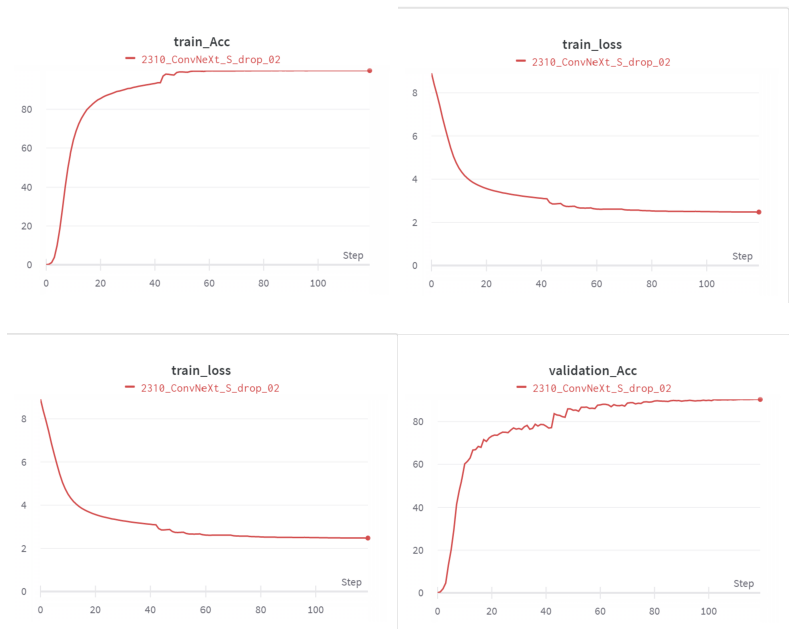

In [ ]:
img_files = []
for f in sorted(os.listdir("/content")):
    if f[-3:] == "png": 
        img_files.append(Image.open(f))

fig, ax = plt.subplots(2, 2, figsize=(14, 12))
plt.subplots_adjust(wspace=0, hspace=0)
for row in range(2):
    for col in range(2):
        ax[row, col].imshow(img_files[row+col])
        ax[row, col].axis("off")

plt.show()

---

# VI. Face Recognition and Verification Tasks

### Face Recognition Task

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

### Face Verification Task

In [ ]:
# Fuction for normalizing the verification image
def normalize_imgs(imgs):
    to_tensor = torchvision.transforms.ToTensor()
    output_imgs = []
    for img in imgs:
        img = to_tensor(img)
        mean = img.mean((1, 2))
        std = img.std((1, 2))
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])
        img_norm = normalize(img)
        output_imgs.append(img_norm)
    return torch.stack(output_imgs)


In [ ]:
known_regex = "/content/data/verification/known/*/*"
unknown_regex = "/content/data/verification/unknown_dev/*" #Change the directory accordingly for the test set
unknown_test = "/content/data/verification/unknown_test/*"

known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))] 

# We load the images from known and unknown folders
unknown_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test)))]

unknown_imgs_norm = normalize_imgs(unknown_images)
known_imgs_norm = normalize_imgs(known_images)
unknown_test_norm = normalize_imgs(unknown_test_images)

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 


100%|██████████| 200/200 [00:00<00:00, 13748.21it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15374.79it/s]

100%|██████████| 800/800 [00:00<00:00, 11499.00it/s]


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()


    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] 
        
        with torch.no_grad():

            unknown_feat, _ = model(unknown_batch.float().to(device), return_feats=True)   
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():

              known_feat, _ = model(known_batch.float().to(device), return_feats=True)  
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])

    predictions = similarity_values.argmax(0).cpu().numpy()

    pred_id_strings = [known_paths[i] for i in predictions]
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/verification/dev_identities.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    

    return pred_id_strings

In [ ]:
pred_id_strings = eval_verification(unknown_imgs_norm, known_imgs_norm, model, similarity_metric, config['batch_size'], mode='val')

Verification Accuracy = 0.715
